In [10]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import pickle,psutil,keras,numpy as np,tensorflow as tf
import keras.layers as kl
from funcy                     import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline

# basic configs
conv_config = {'padding':'same',
               'kernel_initializer':'he_normal',
               'kernel_regularizer': keras.regularizers.l2(0.0005), #weight_decay
               'use_bias':False}

# insuring image data channel is at last axis 
channel_axis = 1 if keras.backend.image_data_format() == 'channels_first' else -1
keras.backend.image_data_format()
# keras.backend..set_image_data_format('channels_first')

'channels_last'

In [3]:
# Utility functions.

def ljuxt(*fs): return rcompose(juxt(*fs), list)

def bn():return kl.BatchNormalization(axis=channel_axis)
def relu():return kl.Activation('relu')

def conv(filter_size, kernel_size, stride_size=1):return kl.Conv2D(filter_size, kernel_size=kernel_size,strides=stride_size, **conv_config)

def convDW(kernel_size, stride_size=1):
    return kl.DepthwiseConv2D(kernel_size=kernel_size,strides=stride_size, depth_multiplier=1, **conv_config)

def conv3x3(filter_size,stride_size=1):return conv(filter_size, kernel_size=(3,3), stride_size=stride_size)
def conv1x1(filter_size,stride_size=1):return conv(filter_size, kernel_size=(1,1), stride_size=stride_size)

def convDW3x3(stride_size=1):return convDW( kernel_size=(3,3), stride_size=stride_size)
def convDW1x1(stride_size=1):return convDW( kernel_size=(1,1), stride_size=stride_size)

def add():return kl.Add()
def GlobalAvgPool():return kl.GlobalAveragePooling2D()
def avgPool(pool_size=2,strides=2):return kl.AveragePooling2D(pool_size=pool_size,strides=strides)

def dense(unit_size, activation): return kl.Dense(unit_size, activation=activation, kernel_regularizer=conv_config['kernel_regularizer'])  

class LossHistory(keras.callbacks.Callback):
    def __init__(self,name,logs = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}):
        super(keras.callbacks.Callback, self).__init__()
        self.logs=logs;self.name = name
    def on_epoch_end(self,epoch,logs={}):
        for i in self.logs.keys():self.logs[i].append(logs.get(i))
        self.tofile()
    def tofile(self,):
        with open(self.name+'.pickle', 'wb') as f: pickle.dump(self.logs, f)
    def readfile(self,):
        with open(self.name+'.pickle', 'rb') as f: self.logs = pickle.load(f)
    def plot(self,metric='acc',start=0):
        for i in [metric,'val_'+metric]:plt.plot(hist.logs[i][start:], marker='.')
        plt.title(self.name+' '+metric)
        plt.xlabel('epoch');plt.ylabel(metric);plt.legend([metric, 'val_'+metric], loc='upper left');
        plt.grid();plt.show()
    def plot_history(self,start=0): self.plot(metric='acc',start=start);self.plot(metric='loss',start=start)

In [4]:
def MobileNetv2(classes,dropout=None):
    """MobileNetv2"""
    chs     = iter([32,16,24,32,64,96,160,320,1280])
    tchs    = iter([   1 ,6 ,6 ,6 ,6 ,6  ,6       ])
    strides = iter([1, 1 ,2 ,2 ,2 ,1 ,2  ,1  ,1   ])
    repts   =      [   1, 2 ,3 ,4 ,3 ,3  ,1       ]
    lens,repts=len(repts),iter(repts)
    
    conv3   = lambda ch,st:conv3x3(filter_size=ch,stride_size=st)
    convDW3 = lambda st:convDW3x3(stride_size=st)
    
    conv1   = lambda ch:conv1x1(filter_size=ch,stride_size=1)
    
    def bottleneck_unit(tchs,strides,chs,repts):
        def f(x,tchs=tchs,strides=strides,chs=chs,repts=repts):
            tmp =tchs*int(x.shape[channel_axis])
            x = rcompose(conv1(tmp),bn(),relu(),
                         convDW3(strides), bn(),relu(),
                         conv1(chs),bn(),
                        )(x)
            tmp =tchs*int(x.shape[channel_axis])
            for i in range(repts-1):
                ls = rcompose(conv1(tmp),bn(),relu(),
                              convDW3(1),bn(),relu(),
                              conv1(chs),bn())(x)
                x = add()([x,ls])
            return x
        return f
    return rcompose( conv3(next(chs),next(strides)),bn(),relu(),
                    
                     *[bottleneck_unit(next(tchs),next(strides),next(chs),next(repts))
                     for i in range(lens)],
                    
                     conv1(next(chs)),
                     GlobalAvgPool(),
                     kl.Reshape((1, 1, 1280)),
                     kl.Dropout(dropout, name='Dropout') if dropout is not None else identity,
                     conv1(classes),
                     kl.Activation('softmax', name='softmax'),
                     kl.Reshape((classes,))
                   )

In [5]:
inputs = kl.Input(shape=(224,224,3))
MobileNetv2(classes=1000,dropout=0.3)(inputs)
# model = keras.Model(inputs,MobileNetv2(classes=1000,dropout=0.3)(inputs))
# model.compile(keras.optimizers.SGD(lr=0.9,nesterov=True), 'categorical_crossentropy', ['acc'])

<tf.Tensor 'reshape_2/Reshape:0' shape=(?, 1000) dtype=float32>

In [6]:
(training_x, training_y), (test_x,test_y) = keras.datasets.cifar10.load_data() 
training_x = training_x /255.0
test_x = test_x /255.0
training_y,test_y = map(keras.utils.np_utils.to_categorical,(training_y,test_y))
class_size = len(training_y[0])

In [7]:
from skimage.transform import resize
# @dask.delayed
def resizef(size=2):
    return lambda x:resize(x, (x.shape[0] // size, x.shape[1] // size),mode='constant')
# training_x_resized = {}
# training_x_resized[8] = np.asarray(list(map(resizef(8),training_x)))
# training_x_resized[4] = np.asarray(list(map(resizef(4),training_x)))
# training_x_resized[2] = np.asarray(list(map(resizef(2),training_x)))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_4 (

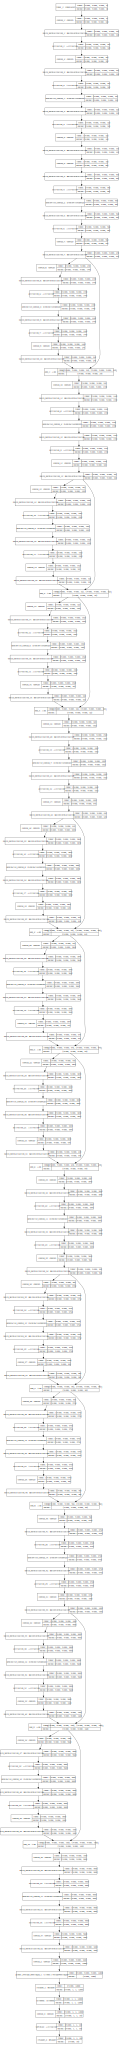

In [11]:
tf.reset_default_graph()
inputs = kl.Input(shape=(None,None,3))
model = keras.Model(inputs,MobileNetv2(classes=class_size,dropout=0.3)(inputs))
model.name='MobileNetv2';hist=LossHistory(model.name)
model.summary()
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [100]:
from keras.preprocessing.image import ImageDataGenerator 
imdgen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 5,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False,  # randomly flip images
    zoom_range = 0.05, # Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
#     rescale = 1.0/255, #  rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (before applying any other transformation).
)
# fmon = keras.callbacks.FitMonitor(thresh=0.03, minacc=0.98)  # this is from our kerutils module (see above)
model.compile('adam',
              #keras.optimizers.SGD(decay=1e-6, momentum=0.9, nesterov=True),
              'categorical_crossentropy', ['acc'])

In [121]:
try: initial_epoch
except NameError as e : initial_epoch=0
initial_epoch = len(list(hist.logs.values())[0])

training_set = training_x#training_x_resized[2]
batch_size=256
epochs=1
model.fit_generator(
    imdgen.flow(training_set, training_y, batch_size=batch_size),
    steps_per_epoch = training_x.shape[0]//batch_size,
    
    initial_epoch = initial_epoch,
    epochs = epochs+initial_epoch,
    
    validation_data = (test_x,test_y),
    verbose = 1,
    callbacks = [hist],
)

Epoch 840/840
195/195 [==============================] - 52s 268ms/step - loss: 0.2785 - acc: 0.9509 - val_loss: 0.4908 - val_acc: 0.8956


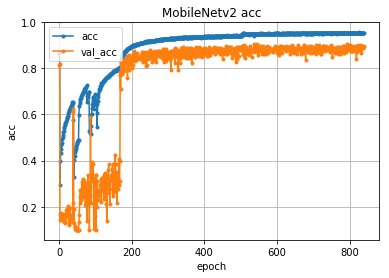

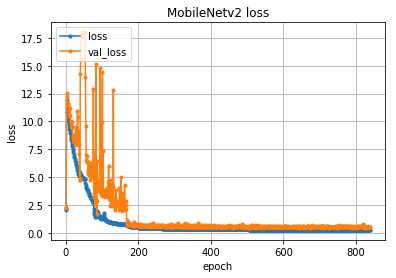

In [135]:
hist.plot_history(start=0)